In [1]:
import requests
import os
import time
import datetime
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import pandas as pd
import matplotlib.pyplot as plt


In [71]:
TOKEN = "0018f1693cd0d70cc31bc3d1554efb839e136eb0eb80ec0500fad16581faf39a13437d26dfdd50ddb7afc"

In [3]:
class Data():
    def __init__(self):
        self.texts = []
        self.id_list = []
        self.date_list = []
    
    def add_data(self, text):
        self.texts.append(text['text'])
        self.id_list.append(text['id'])
        self.date_list.append(text['date'])  
    def add_texts(self, texts):
        for text in texts:
            self.add_data(text)   
    
   
        
        
class VKPosts(Data):
     def __init__(self):
        super().__init__()
        self.group_name_id = {}

        
class VKComments(Data):
    def __init__(self):
        super().__init__()
        self.post_id = []
        self.group_name = []
    def add_data(self, text):
        self.texts.append(text['text'])
        self.id_list.append(text['id'])
        self.date_list.append(text['date'])  
    def add_texts(self, texts):
        for text in texts:
            self.add_data(text)   
            self.post_id.append(text['post_id'])
    def add_comments(self,comments):
        for comment in comments:
            if comment['thread']['count']==0:
                self.add_data(comment)
                self.post_id.append(comment['post_id'])
            else:
                self.add_data(comment)
                self.post_id.append("")
                self.add_texts(comment['thread']['items'])

In [70]:
class VKHarvester:
    def __init__(self, token, group_names, count = 20, thread_items_count = 10):
        self.token = token
        self.group_names = group_names 
        self.count = count
        self.version = "5.131"
        self.vk_posts = VKPosts()
        self.thread_items_count = thread_items_count
        self.vk_comments = VKComments()
    
    def get_posts(self, group_name):
        posts = requests.get(
        'https://api.vk.com/method/wall.get',
        params={
                "domain": group_name,
                "v":self.version,
                "count": self.count,
                "access_token": self.token,
            }
        ).json()["response"]['items']
        self.vk_posts.add_texts(posts)
        return posts
    
    def get_group_id(self, group_name):
        group_id = requests.get(
            'https://api.vk.com/method/utils.resolveScreenName',
            params={
                "screen_name": group_name,
                "v":self.version,
                "access_token": self.token
            }
        ).json()["response"]["object_id"]
        return group_id
    
    def get_comments(self, group_id, post_id):
        time.sleep(1)
        comments = requests.get(
            'https://api.vk.com/method/wall.getComments',
            params={
                "owner_id": -group_id,
                "v":"5.124",
                "post_id":post_id,
                "thread_items_count":self.thread_items_count,
                "access_token": self.token, 
            }
          ).json()['response']['items']
        self.vk_comments.add_comments(comments)
    
    
    def get_data(self):
        for group in self.group_names:
            try:
                group_id = self.get_group_id(group)
            except KeyError as e:
                print("Error:", e)
                break
            posts = self.get_posts(group)
            for post in posts:
                self.get_comments(group_id, post['id'])
    def get_df(self):
        df_posts = pd.DataFrame()
        df_posts["id"] = self.vk_posts.id_list
        df_posts["text"] = self.vk_posts.texts
        df_posts["date"] = self.vk_posts.date_list
        df_comments = pd.DataFrame()
        df_comments["id"] = self.vk_comments.id_list
        df_comments["text"] = self.vk_comments.texts
        df_comments["date"] = self.vk_comments.date_list
        df_comments["post_id"] = self.vk_comments.post_id

        return df_posts, df_comments

In [5]:
class SentimentAnalysis():
    def __init__(self, texts, model):
        self.model = model
        self.texts = texts
        self.sentiment_list = []
        self.neutral_list = []
        self.negative_list = []
        self.positive_list = []
        
    def get_sentiments(self):
        results = self.model.predict(self.texts, k=2)
        for sentiment in results:
            self.sentiment_list.append(sentiment)
    
    def perform_analysis(self):
        self.get_sentiments()
        for sentiment in self.sentiment_list:
            neutral = sentiment.get('neutral')
            negative = sentiment.get('negative')
            positive = sentiment.get('positive')
            if neutral is None:
                self.neutral_list.append(0)
            else:
                self.neutral_list.append(sentiment.get('neutral'))
            if negative is None:
                self.negative_list.append(0)
            else:
                self.negative_list.append(sentiment.get('negative'))
            if positive is None:
                self.positive_list.append(0)
            else:
                self.positive_list.append(sentiment.get('positive'))
        return self.neutral_list, self.negative_list, self.positive_list

In [ ]:
class Visual():
    def __init__(self, df, x, y):
        self.df = df
        self.x = x
        self.y = y
    def plot(self):
        if len(self.y) == 1:
            self.df.plot.scatter(y=self.y[0], x=self.x, marker='o', figsize=(9,7))
        elif len(self.y) == 2:
            ax = self.df.plot.scatter(y=self.y[0], x=self.x, marker='o', figsize=(9,7))
            self.df.plot.scatter(y=self.y[1], x=self.x, marker='o',color = "r", figsize=(9,7), ax = ax)
        elif len(self.y) == 3:
            ax = self.df.plot.scatter(y=self.y[0], x=self.x, marker='o', figsize=(9,7))
            ax2 = self.df.plot.scatter(y=self.y[1], x=self.x, marker='o',color = "r", figsize=(9,7), ax = ax)
            self.df.plot.scatter(y=self.y[2], x=self.x, marker='o',color = "r", figsize=(9,7), ax = ax2)


In [72]:
VK = VKHarvester(TOKEN, ["sysblok"])
VK.get_data()
posts, comments = VK.get_df()

In [15]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)


In [17]:
post_sentiments = SentimentAnalysis(posts['text'].to_list(), model)
neutral_list, negative_list, positive_list = post_sentiments.perform_analysis()
posts["neutral"] = neutral_list
posts["negative"] = negative_list
posts["positive"] = positive_list

In [19]:
comments_sentiments = SentimentAnalysis(comments['text'].to_list(), model)
neutral_list, negative_list, positive_list = comments_sentiments.perform_analysis()
comments["neutral"] = neutral_list
comments["negative"] = negative_list
comments["positive"] = positive_list

In [28]:
from datetime import datetime
posts["datetime"] = [datetime.utcfromtimestamp(date).strftime('%H:%M:%S') for date in posts["date"].to_list()]

In [40]:
def get_modified_dates(date_column):
    new_dates = [datetime.utcfromtimestamp(date).strftime('%H') 
                 for date in date_column]
    return new_dates


In [41]:
comments["datetime"] = get_modified_dates(comments["date"].to_list())

In [42]:
comments

,id,text,date,post_id,neutral,negative,positive,datetime
0,9968,потрясающее! Рассмотреть Блока с такой стороны...,1643378265,9743,0.672342,0.217348,0.000000,13
1,10075,"Да вот, очень интересно: что движет этими людь...",1645962039,9743,0.407343,0.445540,0.000000,11
2,10305,Самоуважение это незнакомое слово для подобных...,1647322987,9743,0.812877,0.000000,0.228166,05
3,10313,Это гуманитарный проект. Если ваши родственник...,1647892612,9743,0.867046,0.164526,0.000000,19
4,10336,,1648660372,10335,1.000010,0.000010,0.000000,17
...,...,...,...,...,...,...,...,...
64,10089,Вангую: ценник на защиту диссертации кандидата...,1646327148,10084,0.893319,0.000000,0.000000,17
65,10093,,1646343959,,1.000010,0.000010,0.000000,21
66,10099,"[id1857305|Стас], в чем русофобия? они что, ру...",1646383716,10084,0.782673,0.399822,0.000000,08
67,10104,"[id1857305|Стас], это русские нацисты, это вы ...",1646396891,10084,0.562187,0.515630,0.000000,12


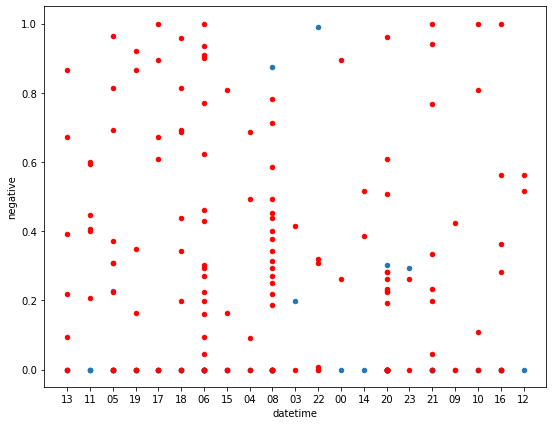

In [68]:

Vis = Visual(comments, "datetime", ["positive", "neutral", "negative"])
Vis.plot()
            
